# Build a base model for the Human Protein Atlas - Single Cell Classification Competition using Tensorflow and Keras

## Introduction

Datasets:
 [Human Protein Atlas - Single Cell Classification Dataset](https://www.kaggle.com/c/hpa-single-cell-image-classification/data).

Package documentation:

(1) [Keras DenseNet121](https://keras.io/api/applications/densenet).

(2) [Tensorflow Module: tf.keras.layers.experimental.preprocessing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/).

(3) [Tensorflow Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation).

(4) [Tensorflow Image classification](https://www.tensorflow.org/tutorials/images/classification).

(5) [Tensorflow Image dataset from directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory).

(6) [scikit-learn MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html#sklearn.preprocessing.MultiLabelBinarizer).


Table of Content:

1. Importing the Libraries

2. Importing the dataset.

3. Preprocessing:

(3.1) Get unique single-cell image identifiers and multilabels.

4. Train and validation split.

 (4.1)Configure dataset for performance.

5. Model definition.

6. Result



## 1.Importing the required Libraries.


Glob: (Filename pattern matching )used to listall files in a directory and it subdirectories that match a file search pattern. Also reads the file and searches for the matching text.

Shutil:This module helps in automating the process of copying and removal of files and directories. Also, offers high-level operation on a file.

tqdm:progressbar decorator for iterators.

PIL:Python Imaging Library which provides the python interpreter with image editing capabilities.



In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import warnings 
import os,gc,cv2
import shutil
import random
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop


%matplotlib inline
warnings.filterwarnings('ignore')

## 2. Importing the data from directories.

In [2]:
# directories 
CELL_IMG='../input/hpa-cell-tiles-sample-balanced-dataset/cells/'
CELL_DF='../input/hpa-cell-tiles-sample-balanced-dataset/cell_df.csv'

## 3. Pre-processing

### (3.1) Get unique single-cell image identifiers and multilabels

In [3]:
# loads train dataframe
train_df=pd.read_csv(CELL_DF)
train_df.head(n=10)

,image_id,r_mean,g_mean,b_mean,cell_id,image_labels,size1,size2
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.019785,0.007022,0.081189,1,0,510,656
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.021645,0.011319,0.059531,2,0,875,748
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.026710,0.014573,0.054268,3,0,924,760
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.018123,0.009205,0.065854,4,0,844,538
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.029577,0.014019,0.037737,5,0,620,1168
5,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.040529,0.008827,0.062398,6,0,472,476
6,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.061733,0.026504,0.071511,7,0,428,555
7,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.040644,0.010379,0.047766,8,0,578,640
8,6166673c-bbad-11e8-b2ba-ac1f6b6435d0,0.074895,0.037825,0.112530,1,0,270,313
9,6166673c-bbad-11e8-b2ba-ac1f6b6435d0,0.036115,0.012050,0.106811,2,0,408,208


### (3.2) Splitting the data into features and labels.

In [4]:

# spliting label column
train_df["image_labels"] = train_df["image_labels"].str.split("|")

# class labels
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18']



  0%|          | 0/19 [00:00<?, ?it/s]

### (3.3) Binarizing each label/class

In [ ]:

for label in tqdm(class_labels):
    train_df[label] = train_df['image_labels'].map(lambda result: 1 if label in result else 0)

# rename column
train_df.columns = ['image_id', 'r_mean', 'g_mean', 'b_mean', 'cell_id', 'image_labels', 'size1', 'size2', 'Nucleoplasm', 'Nuclear membrane', 'Nucleoli', 'Nucleoli fibrillar center',
                    'Nuclear speckles', 'Nuclear bodies', 'Endoplasmic reticulum', 'Golgi apparatus', 'Intermediate filaments',
                    'Actin filaments', 'Microtubules', 'Mitotic spindle', 'Centrosome', 'Plasma membrane', 'Mitochondria',
                    'Aggresome', 'Cytosol', 'Vesicles and punctate cytosolic patterns', 'Negative']

In [5]:
train_df.head()

,image_id,r_mean,g_mean,b_mean,cell_id,image_labels,size1,size2,Nucleoplasm,Nuclear membrane,...,Actin filaments,Microtubules,Mitotic spindle,Centrosome,Plasma membrane,Mitochondria,Aggresome,Cytosol,Vesicles and punctate cytosolic patterns,Negative
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.019785,0.007022,0.081189,1,[0],510,656,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.021645,0.011319,0.059531,2,[0],875,748,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.026710,0.014573,0.054268,3,[0],924,760,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.018123,0.009205,0.065854,4,[0],844,538,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.029577,0.014019,0.037737,5,[0],620,1168,1,0,...,0,0,0,0,0,0,0,0,0,0


### (3.4) Creating a new column with unique identifiers for single-cell images

In [6]:


multinames = ['id', 'r_mean', 'g_mean', 'b_mean', 'image_labels', 'size1', 'size2', 'Nucleoplasm', 'Nuclear membrane', 'Nucleoli', 'Nucleoli fibrillar center',
                    'Nuclear speckles', 'Nuclear bodies', 'Endoplasmic reticulum', 'Golgi apparatus', 'Intermediate filaments',
                    'Actin filaments', 'Microtubules', 'Mitotic spindle', 'Centrosome', 'Plasma membrane', 'Mitochondria',
                    'Aggresome', 'Cytosol', 'Vesicles and punctate cytosolic patterns', 'Negative']
cell_df=train_df
cell_df["id"] = cell_df['image_id'] +'_'+ cell_df['cell_id'].astype(str) 
cell_df["id"] =  cell_df["id"] + '.jpg'
cell_df=cell_df.drop( columns=['image_id', 'cell_id'] )
cell_df=cell_df.reindex( columns= multinames ) 
cell_df.head()

,id,r_mean,g_mean,b_mean,image_labels,size1,size2,Nucleoplasm,Nuclear membrane,Nucleoli,...,Actin filaments,Microtubules,Mitotic spindle,Centrosome,Plasma membrane,Mitochondria,Aggresome,Cytosol,Vesicles and punctate cytosolic patterns,Negative
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_1.jpg,0.019785,0.007022,0.081189,[0],510,656,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_2.jpg,0.021645,0.011319,0.059531,[0],875,748,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_3.jpg,0.026710,0.014573,0.054268,[0],924,760,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_4.jpg,0.018123,0.009205,0.065854,[0],844,538,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0_5.jpg,0.029577,0.014019,0.037737,[0],620,1168,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# change order of ids as in the cells folder
cell_df=cell_df.sort_values('id', axis=0, ascending=True, inplace=False, 
                            kind='quicksort', na_position='last')
cell_df.head()

,id,r_mean,g_mean,b_mean,image_labels,size1,size2,Nucleoplasm,Nuclear membrane,Nucleoli,...,Actin filaments,Microtubules,Mitotic spindle,Centrosome,Plasma membrane,Mitochondria,Aggresome,Cytosol,Vesicles and punctate cytosolic patterns,Negative
9889,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_1.jpg,0.029838,0.049161,0.059588,"[7, 1, 2, 0]",138,480,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9898,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_10.jpg,0.043967,0.054613,0.060938,"[7, 1, 2, 0]",432,342,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9899,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_11.jpg,0.040318,0.033774,0.052175,"[7, 1, 2, 0]",336,508,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9900,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_12.jpg,0.022636,0.028688,0.027753,"[7, 1, 2, 0]",520,654,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9901,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_13.jpg,0.056131,0.049325,0.075091,"[7, 1, 2, 0]",412,384,1,1,1,...,0,0,0,0,0,0,0,0,0,0


### (3.5) Define multilabels for training

In [1]:

multilabels = ['Nucleoplasm', 'Nuclear membrane', 'Nucleoli', 'Nucleoli fibrillar center',
                    'Nuclear speckles', 'Nuclear bodies', 'Endoplasmic reticulum', 'Golgi apparatus', 'Intermediate filaments',
                    'Actin filaments', 'Microtubules', 'Mitotic spindle', 'Centrosome', 'Plasma membrane', 'Mitochondria',
                    'Aggresome', 'Cytosol', 'Vesicles and punctate cytosolic patterns', 'Negative']
print( len(multilabels), '\n')

19 



## 4.Train and validation split

Use the tensorflow method 'flow_from_dataframe', as in this [notebook](https://www.kaggle.com/minniekabra/code-3may) 

In [9]:
# constant parameters
IMG_SIZE = 224
BATCH_SIZE = 32

In [10]:
# image generator, rescaling is performed in a pre-processing layer below, 
image_generator = image.ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last',
    preprocessing_function=None,
    validation_split=0.2
)

In [11]:
# train set data flow from dataframe
train_data = image_generator.flow_from_dataframe(
cell_df,
directory=CELL_IMG,
x_col='id',
y_col=multilabels,
class_mode='raw',    
color_mode='rgb',
target_size=(IMG_SIZE, IMG_SIZE),    
batch_size=BATCH_SIZE,
seed=123,
subset='training'
)

Found 139231 validated image filenames.


In [12]:
# validation set data flow from dataframe
validation_data = image_generator.flow_from_dataframe(
cell_df,
directory=CELL_IMG,
x_col='id',
y_col=multilabels,
class_mode='raw',    
color_mode='rgb',
target_size=(IMG_SIZE, IMG_SIZE),    
batch_size=BATCH_SIZE,
seed=123,
subset='validation'
)

Found 34807 validated image filenames.


## 5. Model definition

In [13]:
# constant parameters for model definition
NUM_CLASSES=19

In [14]:
# DenseNet121 model
densenet = DenseNet121(
    include_top=True,
    weights=None,
    input_shape=(IMG_SIZE,IMG_SIZE,3),
    input_tensor=None,
    pooling=None,
    classes=NUM_CLASSES
)

In [19]:
# model definition including a normalization layer and extra layers
model_densenet = Sequential( [
layers.experimental.preprocessing.Rescaling( 1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3) ),
layers.experimental.preprocessing.RandomFlip("horizontal"),
layers.experimental.preprocessing.RandomFlip("vertical"),
layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
layers.experimental.preprocessing.RandomRotation(factor=1.0),
layers.experimental.preprocessing.RandomZoom(height_factor=0.25, width_factor=0.25),
densenet
] )

In [20]:
# shape of the output ndarray 
model_densenet.output

<KerasTensor: shape=(None, 19) dtype=float32 (created by layer 'densenet121')>

In [21]:
# compile model
learning_rate = 1e-3
model_densenet.compile(optimizer=Adam(lr=learning_rate), 
                       loss='binary_crossentropy', metrics=['categorical_accuracy'])

In [22]:
# model summary
model_densenet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_4 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_5 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_translation_2 (Random (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_2 (RandomZoom)   (None, 224, 224, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 19)               

## 6. Training Parameters

In [23]:
# constant training parameters
EPOCHS=10

In [24]:
# callbacks
model_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, verbose=0),
    tf.keras.callbacks.ModelCheckpoint(filepath='./densenet_model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [25]:
history = model_densenet.fit(
train_data,
validation_data=validation_data,
epochs=EPOCHS,
callbacks=model_callbacks     
)

Epoch 1/10
4351/4351 [==============================] - 2677s 611ms/step - loss: 0.1989 - categorical_accuracy: 0.2617 - val_loss: 0.1831 - val_categorical_accuracy: 0.3681
Epoch 2/10
4351/4351 [==============================] - 1448s 333ms/step - loss: 0.1575 - categorical_accuracy: 0.4421 - val_loss: 0.1599 - val_categorical_accuracy: 0.4342
Epoch 3/10
4351/4351 [==============================] - 1515s 348ms/step - loss: 0.1451 - categorical_accuracy: 0.4868 - val_loss: 0.1540 - val_categorical_accuracy: 0.4622
Epoch 4/10
4351/4351 [==============================] - 1457s 335ms/step - loss: 0.1359 - categorical_accuracy: 0.5187 - val_loss: 0.1423 - val_categorical_accuracy: 0.5040
Epoch 5/10
4351/4351 [==============================] - 1399s 322ms/step - loss: 0.1293 - categorical_accuracy: 0.5416 - val_loss: 0.1377 - val_categorical_accuracy: 0.5270
Epoch 6/10
4351/4351 [==============================] - 1268s 291ms/step - loss: 0.1225 - categorical_accuracy: 0.5602 - val_loss: 0.14

## 7. Model Accuracy

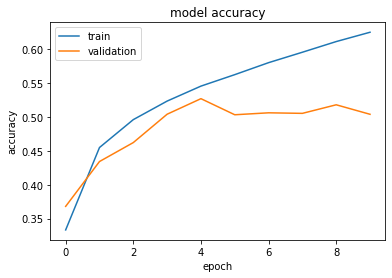

In [26]:
# plot model accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

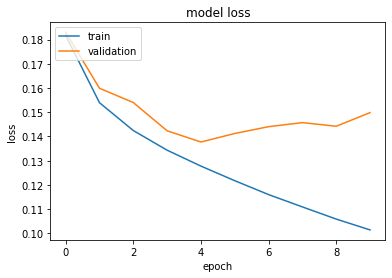

In [27]:
# plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()